# Stock technical Analysis

## Goal for this Notebook:

The goal of this notebook is conduct technical analysis for a given stock ticket. The analysis is performed both in day data and swing data. 

The output of the main function is a plot that assembles a number of different technical factors. This notebook, is part of an algo trading application. If certain criteria are met, then the generated plot is sent as an attachment by email and the recepient decides if will buy or sell the stock under investigation.


In [1]:
from datetime import timedelta, date
import pandas as pd
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import yfinance as yf
import numpy as np
import talib as ta  # install --> https://medium.com/@keng16302/how-to-install-ta-lib-in-python-on-window-9303eb003fbb
import tulipy as ti
import alpaca_trade_api as tradeapi  # pip install alpaca-trade-api
import matplotlib.ticker as mticker
import pylab
import warnings
import random
import os
import datetime

warnings.filterwarnings('ignore')


C:\Users\user\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\user\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\user\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\user\Anaconda3\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [2]:
def lines_intersection_buy_sell(df, col1, col2):
    '''
    the function finds the intersection points of two lines (col1, col2)
    the function does that by finding the sign change, the function assigns the
    positive values to buy and the negative values to sell

    the finction also generates a flag, the flag contains the latest buy or
    sell suggestion and the day that was made
    '''

    df.loc[:, 'dif'] = df[col2] - df[col1]
    dif_values = df['dif'].values

    cros_pos = np.where(np.diff(np.sign(dif_values)))[0] + 1
    dx = df['dif'].iloc[cros_pos]
    dx = dx.dropna()
    dx = dx.iloc[1:]

    dx_pos = dx[dx >= 0]
    dx_neg = dx[dx < 0]

    df_dif_buy = df[df.index.isin(dx_pos.index)][col1]
    df_dif_sell = df[df.index.isin(dx_neg.index)][col2]

    df_dif_buy = pd.merge(df_dif_buy, df.Date, left_index=True, right_index=True)
    df_dif_sell = pd.merge(df_dif_sell, df.Date, left_index=True, right_index=True)

    return (df_dif_buy, df_dif_sell)


In [3]:
def technicalAnalysis(df, close_clm='Close'):
    '''
    Calculating technical factors
    '''
    df = df.dropna()
    n = 14  # number of periods (days)
    try:
        # RSI(Relative Strength Index)
        # RSI is technical analysis indicator
        # https://www.investopedia.com/terms/r/rsi.asp
        df['RSI'] = ta.RSI(np.array(df[close_clm].shift(1)), timeperiod=n)

        # MA(Moving Average)
        # https://www.investopedia.com/terms/m/movingaverage.asp
        df['MA5'] = ta.MA(np.array(df[close_clm]), timeperiod=5, matype=0)
        df['MA9'] = ta.MA(np.array(df[close_clm]), timeperiod=9, matype=0)
        df['MA14'] = ta.MA(np.array(df[close_clm]), timeperiod=14, matype=0)
        df['MA20'] = ta.MA(np.array(df[close_clm]), timeperiod=20, matype=0)
        df['MA50'] = ta.MA(np.array(df[close_clm]), timeperiod=50, matype=0)
        df['MA100'] = ta.MA(np.array(df[close_clm]), timeperiod=100, matype=0)
        # df['MA100'] = ta.MA(np.array(df[close_clm].shift(1)), timeperiod=100, matype=0)

        # SMA(Simple Moving Average)
        # https://www.investopedia.com/terms/s/sma.asp
        df['SMA'] = ta.SMA(np.array(df[close_clm]))

        # EMA(Exponential Moving Average)
        # https://www.investopedia.com/terms/e/ema.asp
        df['ema9'] = ti.ema(df[close_clm].dropna().to_numpy(), 9)
        df['ema14'] = ti.ema(df[close_clm].dropna().to_numpy(), 14)
        df['ema20'] = ti.ema(df[close_clm].dropna().to_numpy(), 20)
        df['EMA'] = ta.EMA(np.array(df[close_clm]), timeperiod=n)
        df['ema26'] = ti.ema(df[close_clm].dropna().to_numpy(), 26)
        df['ema50'] = ti.ema(df[close_clm].dropna().to_numpy(), 50)
        df['ema100'] = ti.ema(df[close_clm].dropna().to_numpy(), 50)
        df['ema200'] = ti.ema(df[close_clm].dropna().to_numpy(), 50)

        try:
            # Volume Weighted Average Price - VWAP
            # http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:vwap_intraday
            df['VWAP'] = round(np.cumsum(df['Volume']*(df['High']+df['Low'])/2) / np.cumsum(df['Volume']), 2)
        except Exception:
            pass

        df['MACD'] = ta.MACD(np.array(df[close_clm]), fastperiod=12, slowperiod=26, signalperiod=9)[0]
        df['MACDsignal'] = ta.MACD(np.array(df[close_clm]), fastperiod=12, slowperiod=26, signalperiod=9)[1]

        price_min = df[close_clm].iloc[-50:].min()
        price_max = df[close_clm].iloc[-50:].max()

        # Fibonacci Levels
        # https://www.investopedia.com/ask/answers/05/fibonacciretracement.asp
        diff = price_max - price_min
        df['level236'] = price_max - 0.236 * diff
        df['level382'] = price_max - 0.382 * diff
        df['level618'] = price_max - 0.618 * diff
        df['level50'] = price_max - 0.50 * diff
        df['level100'] = price_max - 1 * diff
        df['level0'] = price_max - 0 * diff

        # stoch Analysis
        # https://www.investopedia.com/terms/s/stochasticoscillator.asp
        df['stoch_k'] = 0
        df['stoch_d'] = 0
        stoch_k_full, stoch_d_full = ti.stoch(
                            df['High'].values,
                            df['Low'].values,
                            df[close_clm].values,
                            9, 6, 9)  # parameters for the curves
        df['stoch_k'].iloc[-len(stoch_k_full):] = stoch_k_full
        df['stoch_d'].iloc[-len(stoch_d_full):] = stoch_d_full

        # Ichimoku Cloud
        # https://www.investopedia.com/terms/i/ichimoku-cloud.asp
        CL_period = 20  # length of Tenkan Sen or Conversion Line
        BL_period = 60  # length of Kijun Sen or Base Line
        Lead_span_B_period = 120  # length of Senkou Sen B or Leading Span B
        Lag_span_period = 30  # length of Chikou Span or Lagging Span
        # add to the dataframe, different components of the Ichimoku
        # use shift function to shift a time series forward by the given value
        df['Conv_line'] = (df.High.shift(CL_period)+df.Low.shift(CL_period))/2
        df['Base_line'] = (df.High.shift(BL_period)+df.Low.shift(BL_period))/2
        df['Lead_span_A'] = (df['Conv_line'] + df['Base_line'])/2
        df['Lead_span_B'] = (df.High.shift(Lead_span_B_period)+df.Low.shift(Lead_span_B_period))/2
        df['Lagging_span'] = df.Close.shift(Lag_span_period)

        # 20 Days STD
        df['20 Day STD'] = df[close_clm].rolling(window=20).std()
        df['Upper Band'] = df['ema20'] + (df['20 Day STD'] * 2)
        df['Lower Band'] = df['ema20'] - (df['20 Day STD'] * 2)


        df = df.round(2)

    except Exception:
        pass
    return df

In [4]:
def gatherAllTickers():
    xl = pd.ExcelFile("swingPortData.xlsx")
    sheets_list = xl.sheet_names

    for sheet in xl.sheet_names:
        if sheet.find("_") != -1:
            sheets_list.remove(sheet)

    dfs = {sheet: xl.parse(sheet) for sheet in xl.sheet_names}

    market_indexes = {'FTSE 100': '^FTSE',  # UK
                      'FTSE 250': '^FTMC',  # UK
                      'NASDAQ Composite': '^IXIC',  # USA
                      'S&P 500': '^GSPC',  # USA
                      'NYSE': '^NYA',  # USA
                      'DAX PERFORMANCE-INDEX': '^GDAXI',  # Germany
                      'CAC 40': '^FCHI'}  # France

    colm_list = ['Company', 'Sector', 'SubSector', 'Ticker', 'Market', 'Market_Symbol']
    df = pd.DataFrame(columns=colm_list)
    for sheet_name in sheets_list:
        dfs[sheet_name]['Market'] = sheet_name
        dfs[sheet_name]['Market_Symbol'] = market_indexes[sheet_name]
        df = df.append(dfs[sheet_name][colm_list])

    return df

In [5]:
def market_change(symbol, md):
    market_index = md[md.Ticker == symbol]['Market_Symbol'].iloc[0]
    market_Name = md[md.Ticker == symbol]['Market'].iloc[0]
    try:
        df_1min_market = yf.download(tickers=market_index, period='5m', interval='1m')['Adj Close']
        marketNow = df_1min_market[-1]
        day_today = df_1min_market.index[-1].day
        marketDay = yf.download(tickers=market_index, period='5d', interval='1d')['Adj Close']
        marketDay = marketDay[marketDay.index.day != day_today][-1]
    except Exception:
        return " / " + market_Name + ": -%"
    return " / " + market_Name + ": " + str(round((marketNow-marketDay)/marketDay*100, 2)) + "%"


In [6]:
def sector_change(symbol, md):
    sector_change = []
    sector_name = md[md.Ticker == symbol]['Sector'].iloc[-1]
    sector_tickers = md[md.Sector == sector_name]['Ticker'].tolist()
    random.shuffle(sector_tickers)
    for ticker_sector in sector_tickers[0:30]:
        if symbol != ticker_sector:
            try:
                df_1min_sector = yf.download(tickers=ticker_sector, period='5m', interval='1m')['Adj Close']
                sectorNow = df_1min_sector[-1]
                day_today = df_1min_sector.index[-1].day
                sectorDay = yf.download(tickers=ticker_sector, period='5d', interval='1d')['Adj Close']
                sectorDay = sectorDay[sectorDay.index.day != day_today][-1]
                sector_change.append(round((sectorNow-sectorDay)/sectorDay*100, 2))
            except Exception:
                pass
    if sector_change == []:
        return " / " + sector_name + ": -%"
    else:
        return " / " + sector_name + ": " + str(round(sum(sector_change) / len(sector_change), 2)) + "%"



In [7]:
def getStockPricesDays(symbol, start, end):
    '''
    Downloading Stocks and adding technical factors
    '''
    df = yf.download(symbol, start, end, threads=False)
    '''https://pypi.org/project/yfinance/'''
    '''https://github.com/ranaroussi/yfinance/issues/363'''
    return df


In [8]:
def getStockPricesMin(ticker, start, end, min_len=False):
    # df = alpaca.get_barset(ticker, '5Min', 100).df[ticker]
    df = yf.download(tickers=ticker, period='2d', interval='5m')

    if min_len:
        df = df.resample('30min').agg({
                            'Open': 'first',
                            'High': 'max',
                            'Low': 'min',
                            'Close': 'last',
                            'Volume': 'sum'
                            })
    # df = df.rename(columns={"open": "Open", "close": "Close", "high": "High", "low": "Low", "volume": "Volume"})
    df.index.names = ['Date']
    return df


In [12]:
def graphData(symbol, df, marketTrend='-', sectorTrend='-', direction='-', JUSTIFICATION='', testing_path=''):
    '''
        Use this to dynamically pull a stock:
    '''
    def set_legend():
        maLeg = plt.legend(loc=2, ncol=1, prop={'size': 5}, fancybox=True, borderaxespad=0.)
        maLeg.get_frame().set_alpha(0.4)
        textEd = pylab.gca().get_legend().get_texts()
        pylab.setp(textEd[0:5], color='w')

    def set_snipes(ax_obj):
        ax_obj.spines['bottom'].set_color("#5998ff")
        ax_obj.spines['top'].set_color("#5998ff")
        ax_obj.spines['left'].set_color("#5998ff")
        ax_obj.spines['right'].set_color("#5998ff")

    fig = plt.figure(facecolor='#07000d', dpi=600)

    if df.empty:
        return

    df = df.reset_index()

    if (df.Date.iloc[-1] - df.Date.iloc[1]).days <= 10:
        SP = 100
        wd = 2/(24*60)
        df = df[df.Date.dt.day == df.Date.iloc[-1].day]
        date_format = '%H:%M'
        chart_type = " - Day Trading"

    else:
        SP = 60
        wd = 0.6
        date_format = '%m-%d'
        chart_type = " - 60 days"
        # JUSTIFICATION = "\n" + JUSTIFICATION

    [k_inter, d_inter] = lines_intersection_buy_sell(df[-SP:], 'stoch_k', 'stoch_d')
    [MACD_inter, MACDSign_inter] = lines_intersection_buy_sell(df[-SP:], 'MACD', 'MACDsignal')

    # Extracting Data for plotting
    ohlc = df[['Date', 'Open', 'High', 'Low', 'Close']].iloc[-SP:]
    ohlc['Date'] = pd.to_datetime(ohlc['Date'])
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
    ohlc['SMA5'] = ohlc['Close'].rolling(5).mean()

    df["Date2"] = df["Date"]

    min_y = df[['High', 'ema9', 'ema14', 'ema20', 'ema50', 'Upper Band', 'Lower Band', 'Lead_span_A', 'Lead_span_B']][-SP:].min().min()
    max_y = df['Close'].iloc[-2]
    vertical_x = [df.Date.iloc[-2], df.Date.iloc[-2]]
    vertical_y = [max_y, min_y]

    # ######################################################################################################
    ax1 = plt.subplot2grid((7, 5), (1, 0), rowspan=4, colspan=5, facecolor='#07000d')
    ax1.plot(df.Date[-SP:], df.ema9[-SP:], '#e1edf9', label='ema9', linewidth=0.25, linestyle='dashed')
    ax1.plot(df.Date[-SP:], df.ema20[-SP:], '#EB28B0', label='ema20', linewidth=0.25, linestyle='dashed')  # white->e1edf9
    ax1.plot(df.Date[-SP:], df.ema50[-SP:], '#EB8728', label='ema50', linewidth=0.25, linestyle='dashed')
    ax1.plot(df.Date[-SP:], df['Upper Band'][-SP:], '#EB28B0', label='U+LBand', linewidth=0.5)
    ax1.plot(df.Date[-SP:], df['Lower Band'][-SP:], '#EB28B0', linewidth=0.5)
    candlestick_ohlc(ax1, ohlc.values, width=wd, colorup='#53c156', colordown='#ff1717')

    # ================================================================
    # Ichimoku
    ax1.plot(df.Date[-SP:], df.Conv_line[-SP:], '#209242', label='Ichimoku-Conv', linewidth=0.3, linestyle='dashdot')  # plot Lead Span A with index on the shared x-axis
    ax1.plot(df.Date[-SP:], df.Base_line[-SP:], '#922020', label='Ichimoku-Base', linewidth=0.3, linestyle='dashdot')  # plot Lead Span A with index on the shared x-axis
    ax1.fill_between(df.Date[-SP:], df.Lead_span_A[-SP:], df.Lead_span_B[-SP:], where=df.Lead_span_A[-SP:] >= df.Lead_span_B[-SP:], color='lightgreen', alpha=0.2)
    ax1.fill_between(df.Date[-SP:], df.Lead_span_A[-SP:], df.Lead_span_B[-SP:], where=df.Lead_span_A[-SP:] < df.Lead_span_B[-SP:], color='lightcoral', alpha=0.2)
 
    # =================================================================
    ax1.xaxis.grid(False)
    ax1.grid(True, linestyle='dotted', color='w', linewidth=0.3)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.xaxis.set_major_formatter(mpl_dates.DateFormatter('%m-%d'))
    ax1.yaxis.label.set_color("w")
    set_snipes(ax1)
    set_snipes(ax1)

    ax1.tick_params(axis='y', colors='w', labelsize=6)
    plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
    ax1.tick_params(axis='x', colors='w')
    plt.ylabel('Stock price and Volume', fontsize=8)
    ax1.yaxis.set_label_coords(-0.065, 0.5)

    if ((df.Date.iloc[-1] - df.Date.iloc[1]).days > 20) and (JUSTIFICATION.find('testing') == -1):  # days
        ax1.plot(vertical_x, vertical_y, '#e1edf9', linewidth=0.5, linestyle='dashed')
    set_legend()  # Function

    # ######################################################################################################
    ax1v = ax1.twinx()
    if (df.Date2.iloc[-1] - df.Date2.iloc[1]).days < 1:
        ax1v.fill_between(df.Date[-SP:], 0, df.Volume[-SP:], facecolor='#00ffe8', alpha=.4)
    else:
        ax1v.bar(df.Date[-SP:], df.Volume[-SP:], facecolor='#00ffe8', alpha=.4)
    ax1v.axes.yaxis.set_ticklabels([])
    ax1v.set_ylim(0, 3*df.Volume.max())
    ax1v.spines['bottom'].set_color("#5998ff")
    ax1v.spines['top'].set_color("#5998ff")
    ax1v.spines['left'].set_color("#5998ff")
    ax1v.spines['right'].set_color("#5998ff")
    ax1v.tick_params(axis='x', colors='w')
    ax1v.tick_params(axis='y', colors='w', labelsize=6)

    # ######################################################################################################
    ax2 = plt.subplot2grid((7, 5), (5, 0), sharex=ax1, rowspan=1, colspan=5, facecolor='#07000d')
    ax2.plot(df.Date[-SP:], df.stoch_k[-SP:], '#41A415', linewidth=0.5, label="k")
    ax2.plot(df.Date[-SP:], df.stoch_d[-SP:], '#DA5E5E', linewidth=0.5, label="d")
    ax2.scatter(d_inter.Date, d_inter.stoch_d, marker='^', c='green', s=12)
    ax2.scatter(k_inter.Date, k_inter.stoch_k, marker='v', c='red', s=12)
    ax2.axhline(80, color='#FF64FA', linewidth=0.25)
    ax2.axhline(20, color='#FF64FA', linewidth=0.25)
    ax2.set_yticks([0, 20, 50, 80, 100])
    ax2.grid(True, linestyle='dotted', color='w', linewidth=0.3)
    ax2.yaxis.label.set_color("w")
    set_snipes(ax2)
    ax2.tick_params(axis='y', colors='w', labelsize=6)
    ax2.tick_params(axis='x', colors='w', labelsize=3)
    ax2.yaxis.set_label_coords(-0.065, 0.5)

    set_legend()  # Function
    plt.ylabel('STOCH', color='w', fontsize=8)

    # ######################################################################################################
    posCol = '#386d13'
    negCol = '#8f2020'

    ax0 = plt.subplot2grid((7, 5), (0, 0), sharex=ax1, rowspan=1, colspan=5, facecolor='#07000d')
    ax0.plot(df.Date[-SP:], df.RSI[-SP:], '#c1f9f7', linewidth=0.74)
    ax0.axhline(70, color=negCol, linewidth=0.75)
    ax0.axhline(30, color=posCol, linewidth=0.75)
    ax0.fill_between(df.Date[-SP:], df.RSI[-SP:], 70, where=(df.RSI[-SP:] >= 70), facecolor=negCol, edgecolor=negCol, alpha=0.5)
    ax0.fill_between(df.Date[-SP:], df.RSI[-SP:], 30, where=(df.RSI[-SP:] <= 30), facecolor=posCol, edgecolor=posCol, alpha=0.5)
    ax0.set_yticks([30, 50, 70])
    ax0.grid(True, linestyle='dotted', color='w', linewidth=0.3)
    ax0.yaxis.label.set_color("w")
    set_snipes(ax0)
    ax0.tick_params(axis='y', colors='w', labelsize=6)
    ax0.tick_params(axis='x', colors='w')
    ax0.yaxis.set_label_coords(-0.065, 0.5)
    plt.ylabel('RSI', fontsize=8)

    # ######################################################################################################
    ax3 = plt.subplot2grid((7, 5), (6, 0), sharex=ax1, rowspan=1, colspan=5, facecolor='#07000d')
    fillcolor = '#00ffe8'
    ax3.plot(df.Date[-SP:], df.MACD[-SP:], color='#218AFA', linewidth=0.5)
    ax3.plot(df.Date[-SP:], df.MACDsignal[-SP:], color='#DA5E5E', linewidth=0.5, label="signal")
    ax3.fill_between(df.Date[-SP:], df.MACD[-SP:]-df.MACDsignal[-SP:], 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)
    ax3.axhline(0, color='#FF64FA', linewidth=0.25)
    plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
    set_snipes(ax3)
    ax3.scatter(MACD_inter.Date, MACD_inter.MACD, marker='v', c='red', s=12)
    ax3.scatter(MACDSign_inter.Date, MACDSign_inter.MACDsignal, marker='^', c='green', s=12)
    ax3.tick_params(axis='x', colors='w', labelsize=8)
    ax3.tick_params(axis='y', colors='w', labelsize=6)
    ax3.grid(True, linestyle='dotted', color='w', linewidth=0.3)
    plt.ylabel('MACD', color='w', fontsize=8)
    ax3.yaxis.set_label_coords(-0.065, 0.5)
    ax3.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='upper'))
    ax3.xaxis.set_major_formatter(mpl_dates.DateFormatter(date_format))
    ax3.xaxis.set_major_locator(mticker.MaxNLocator(10))
    set_legend()  # Function

    for label in ax3.xaxis.get_ticklabels():
        label.set_rotation(0)

    # ######################################################################################################
    # plt.suptitle((symbol + chart_type + ' (' + direction + '@' + str(df['Close'].iloc[-1]) + ') ' + marketTrend + sectorTrend + JUSTIFICATION).upper(), color='w', y=1.025, size=8)
    title_text = (symbol + chart_type + ' (' + direction + '@' + str(df['Close'].iloc[-1]) + ') ' + marketTrend + sectorTrend + JUSTIFICATION).upper()
    plt.figtext(0.5, 0.95, title_text, ha="center", fontsize=7, color='w', bbox={"facecolor": "black", "alpha": 0.0, "pad": 5})
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.subplots_adjust(left=.09, bottom=.1, right=.94, top=.94, wspace=.20, hspace=0.25)
    buy_text = "BUY: fast>slow MA / RSI-->30 / MACD>signal / STOCH: 80>k>d or k<20, MACD after STOCH"
    sell_text = "SELL: fast<slow MA / RSI-->70 / MACD<signal / STOCH: k or d >80, k from 100 to 80"
    plt.figtext(0.05, -0.02, sell_text, ha="left", fontsize=7, color='w', bbox={"facecolor": "black", "alpha": 0.0, "pad": 5})
    plt.figtext(0.05, 0.01, buy_text, ha="left", fontsize=7, color='w', bbox={"facecolor": "black", "alpha": 0.0, "pad": 5})
    plt.show()

    if JUSTIFICATION.find('testing') > 0:
        if testing_path == '':
            testing_path = symbol.replace(".", "_")
        fname = 'testing/' + testing_path + '/' + symbol
        while os.path.isfile(fname + '.png') is True:
            fname = fname + '_X'
        fig.savefig(fname+'.png', facecolor=fig.get_facecolor(), dpi=600, bbox_inches='tight')
    else:
        fig.savefig('stock_chart'+chart_type+'.png', facecolor=fig.get_facecolor(), dpi=600, bbox_inches='tight')



In [10]:
def historic_live_data(symbol, startDate, EndDate):
    dd = getStockPricesDays(symbol, startDate, EndDate)

    dm = getStockPricesMin(symbol, startDate, EndDate)
    dm = technicalAnalysis(dm)

    if dd.empty is False and dm.empty is False:
        dd_last_date = dd.index[-1]+datetime.timedelta(days=1)
        dm_today = dm[dm.index > dd_last_date.strftime('%Y-%m-%d')]
        if dm_today.empty is False:
            dd = dd.append(pd.Series(name=dd.index[-1]+datetime.timedelta(days=1)))
            dd['Open'].iloc[-1] = dm_today['Open'].iloc[0]
            dd['High'].iloc[-1] = dm_today['High'].max()
            dd['Low'].iloc[-1] = dm_today['Low'].min()
            dd['Close'].iloc[-1] = dm_today['Close'].iloc[-1]
            dd['Adj Close'].iloc[-1] = dm_today['Adj Close'].iloc[-1]
            dd['Volume'].iloc[-1] = dm_today['Volume'].sum()

    dd = technicalAnalysis(dd, 'Adj Close')

    return dd, dm

MARKET INDEX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SECTOR INDEX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*******

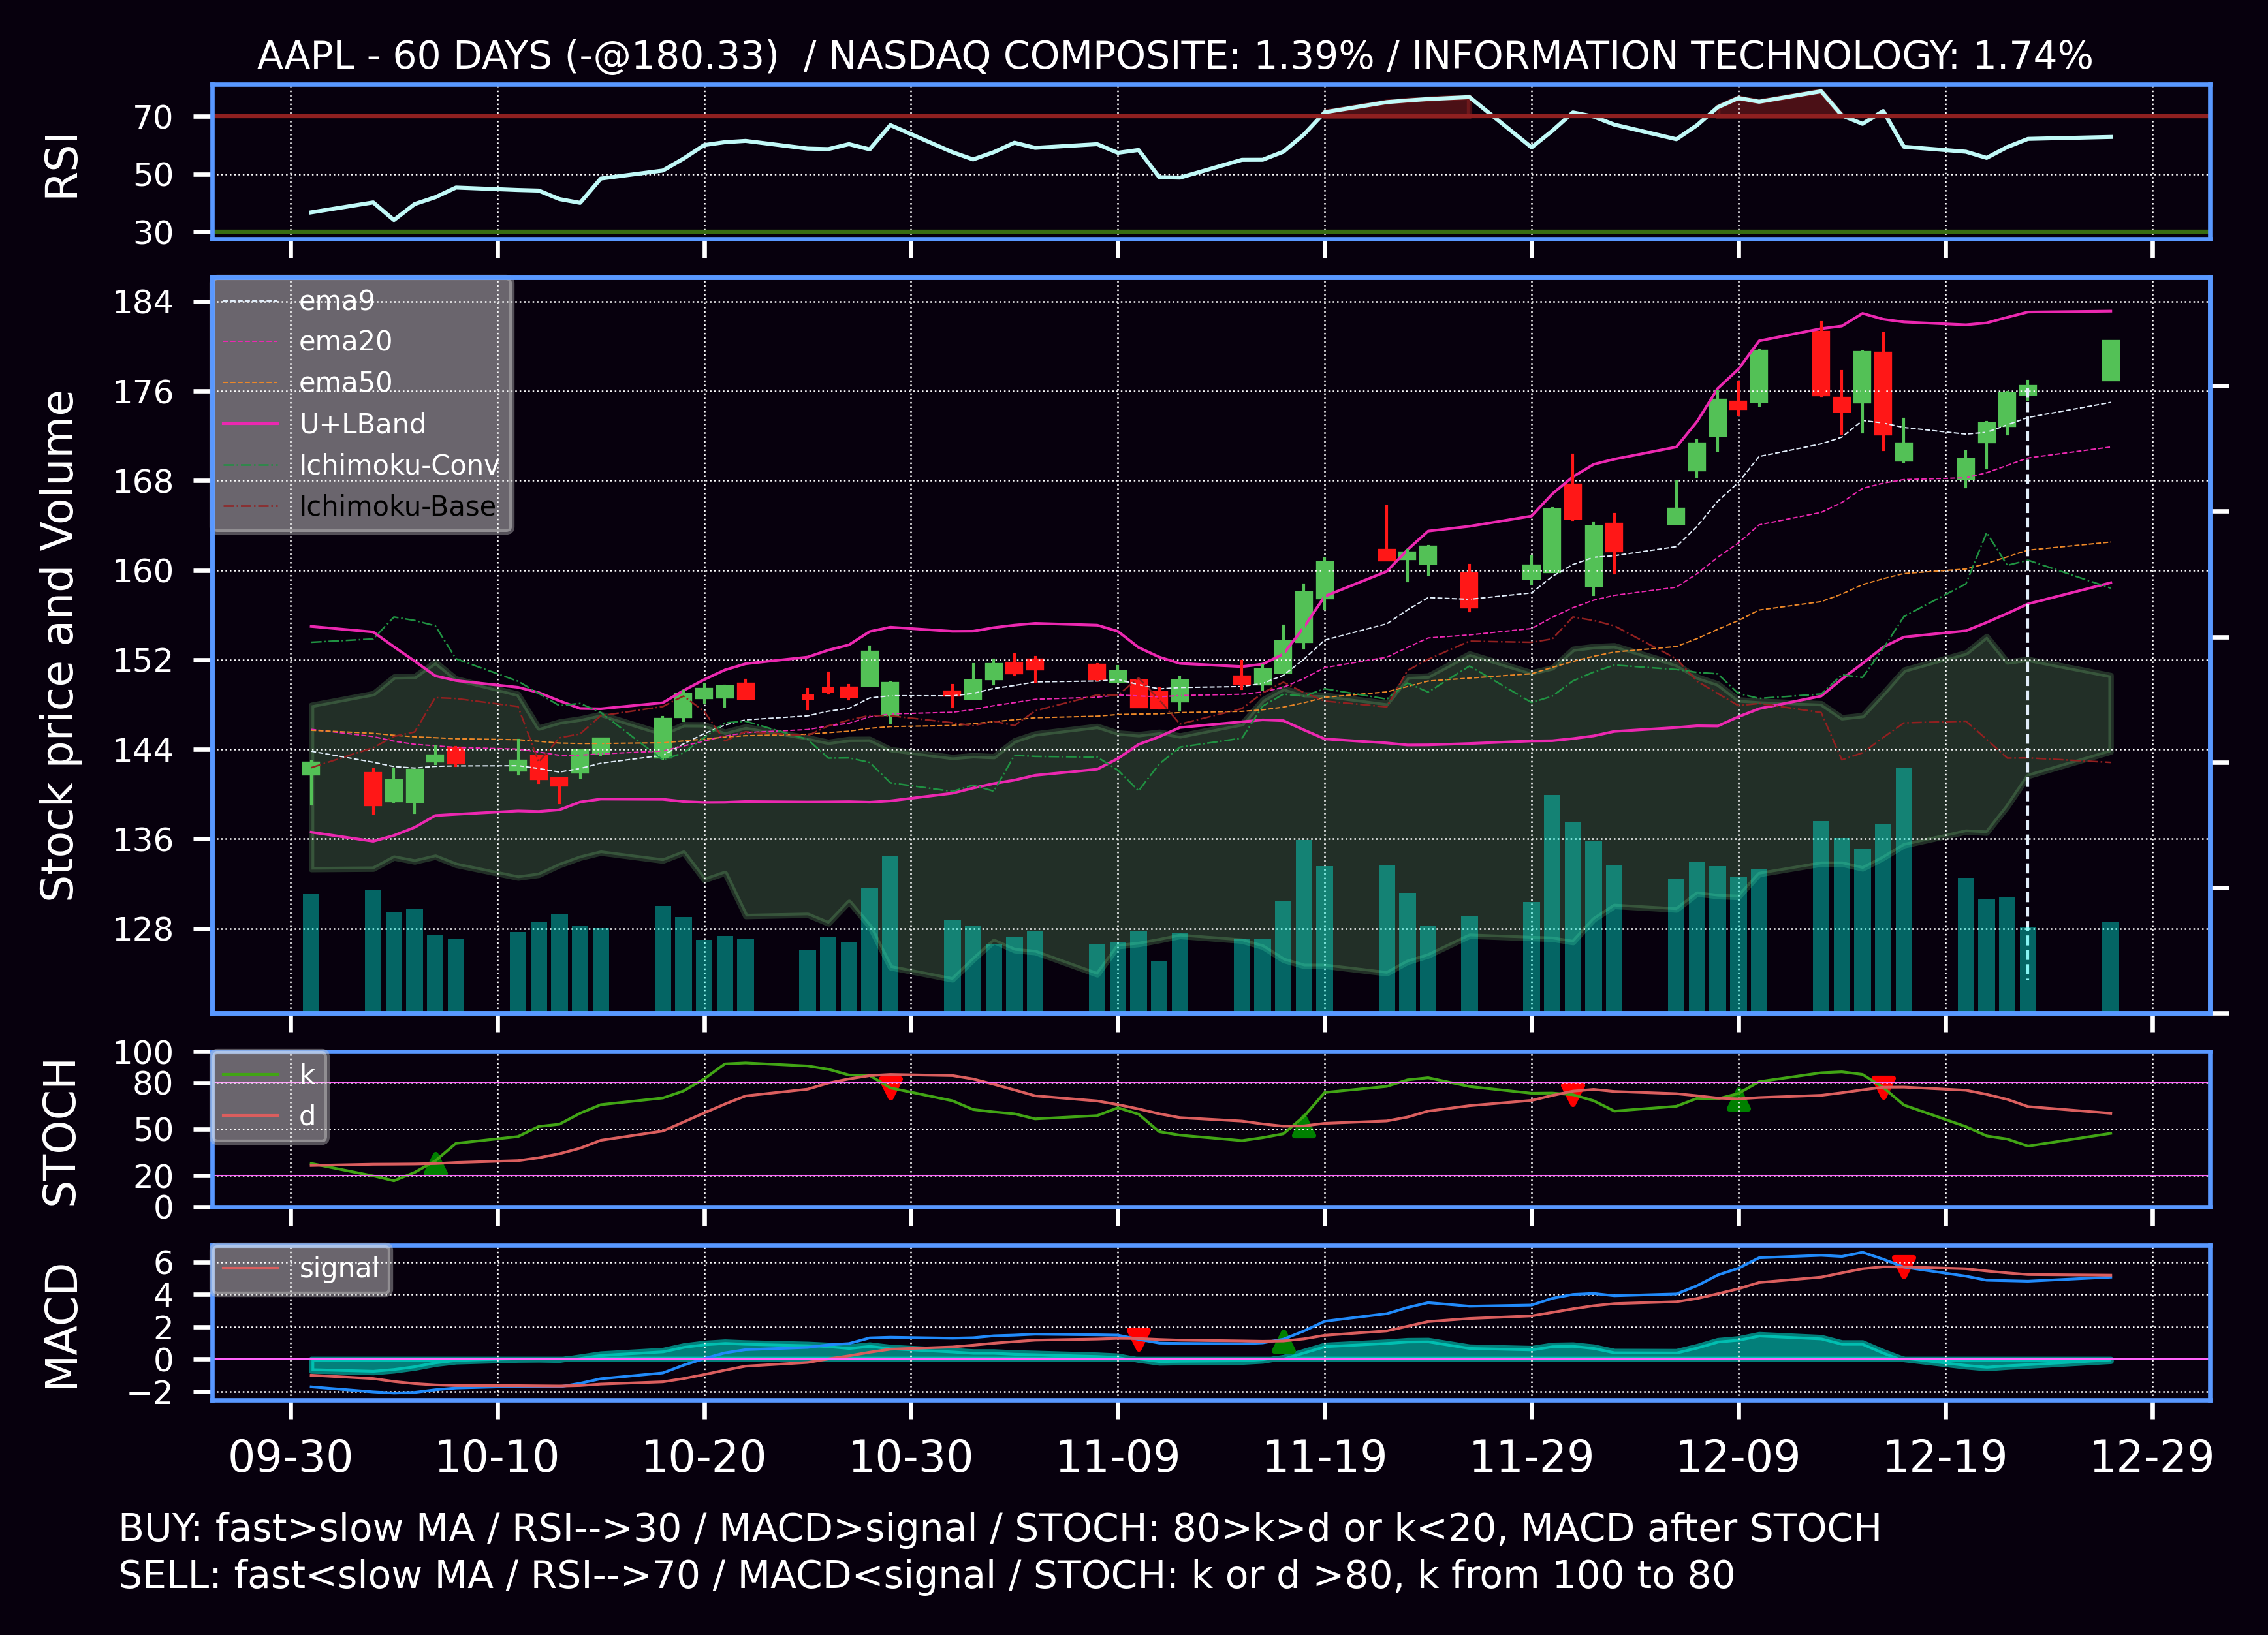

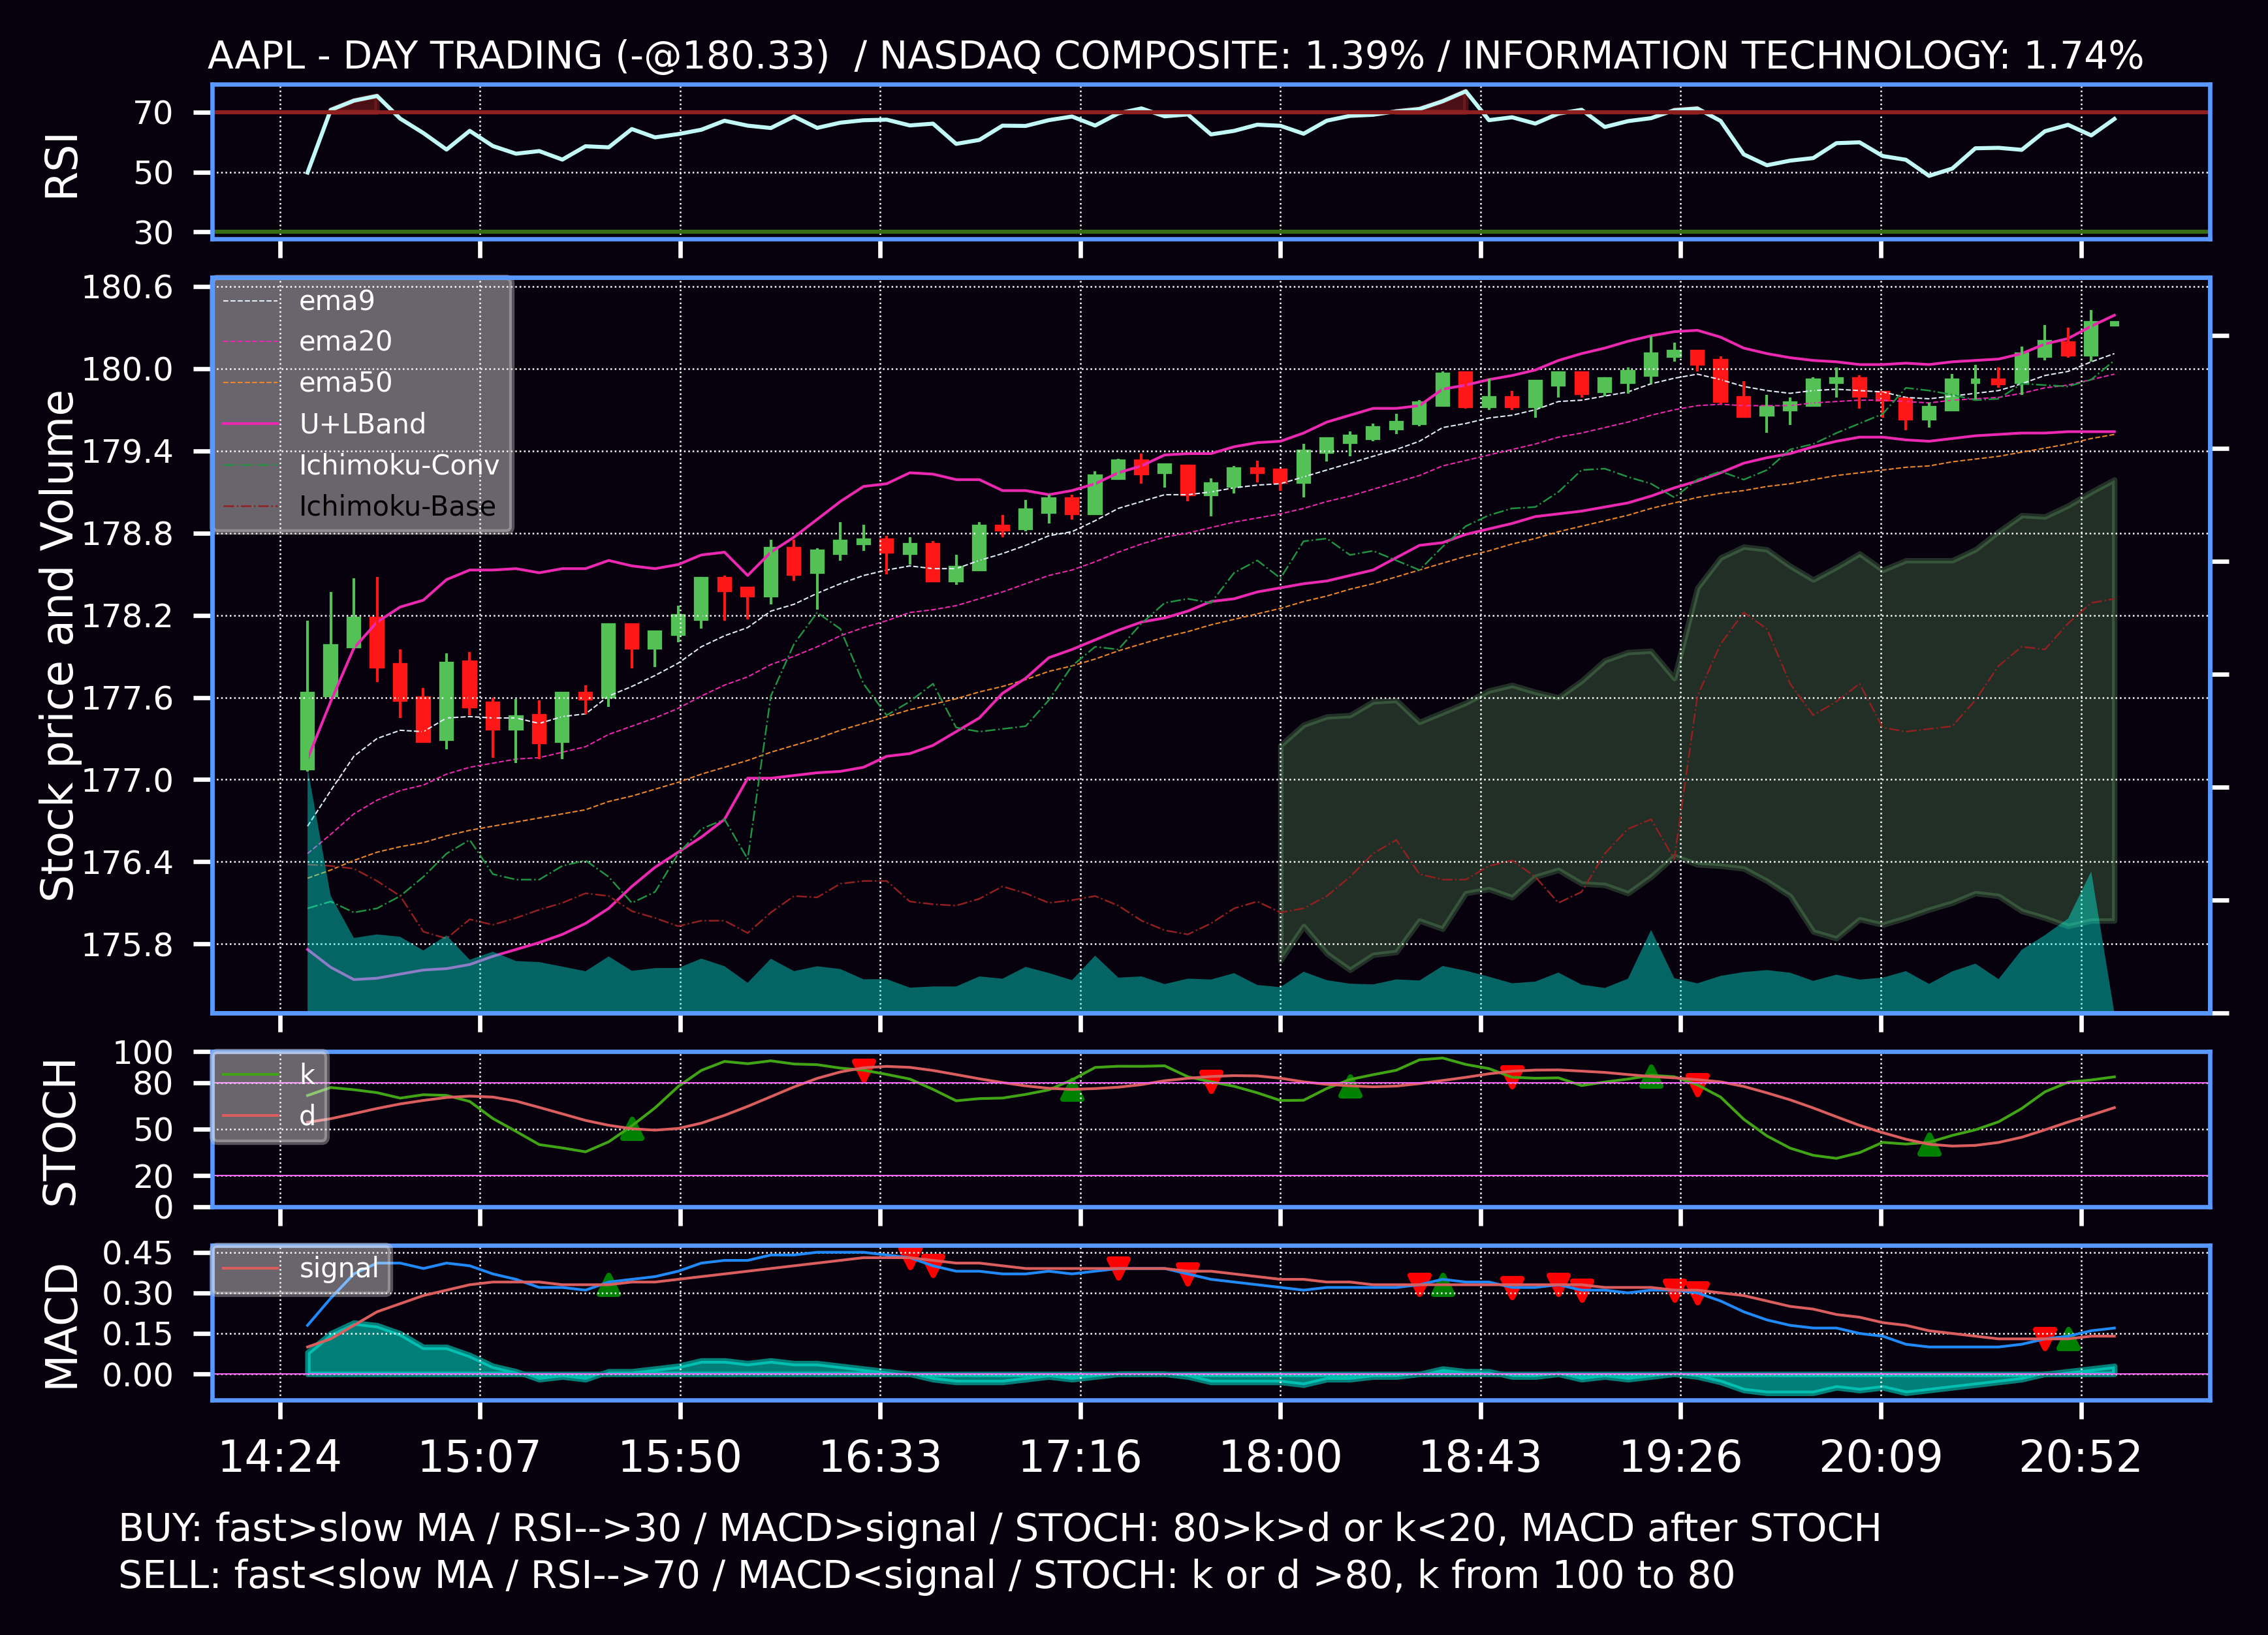

In [13]:
symbol = 'AAPL'

marketData = gatherAllTickers()
print('MARKET INDEX')
marketTrend = market_change(symbol, marketData)
print('SECTOR INDEX')
sectorTrend = sector_change(symbol, marketData)
direction = '-'

startDate = date.today() - timedelta(days=365)
EndDate = date.today()
dd, dm = historic_live_data(symbol, startDate, EndDate)

graphData(symbol, dd, marketTrend, sectorTrend, direction)
graphData(symbol, dm, marketTrend, sectorTrend, direction)
